# NSU, vaje 1: osnove strojnega učenja v Pythonu

In [1]:
import numpy as np
import pandas as pd

A.1: Naložite podatke iz CSV datoteke s paketom **pandas**. 

In [2]:
# Naložimo podatke
df = pd.read_csv('podatki.csv', index_col=0)

A.2: Osnovne informacij o podatkih. Izpišite prvih nekaj vrstic podatkov in si jih oglejte, nato pa izpišite še:
- število vrstic in stolpcev
- vrsto spremenljivke v vsakem stolpcu (v pomoč je funkcija **dtypes**), 
- povzetek statistike (pandas nam pomaga z **describe**), 
- število manjkajočih vrednosti v vsakem stolpcu (koristna je funkcija **isnull**).

In [3]:
# Prve vrstice
print(df.head())

# Število vrstic in stolpcev
print("Velikost podatkov: ", df.shape)

# Tipi stolpcev
print("Tipi stolpcev: ")
print(df.dtypes)

# Povzetek statistike
print("Povzetek statistike: ")
print(df.describe())

# Manjkajoče vrednosti
print("Manjkajoče vrednosti: ")
manjkajoce = df.isnull().sum()
print(manjkajoce)

         X1         X2        X3    X4         X5                X6  Y
1  0.452553  69.113756 -2.558555   car  23.210163               NaN  1
2  0.865373  39.855286 -0.727901  bike  24.136736               NaN  0
3       NaN  82.321769 -6.092819  bike  70.441331  937875.790987164  0
4  0.568116  82.638111 -8.248877   car        NaN  197308.828588575  1
5  0.936621  34.460152 -9.577684   NaN  46.773121  253860.316937789  0
Velikost podatkov:  (500, 7)
Tipi stolpcev: 
X1    float64
X2    float64
X3    float64
X4     object
X5    float64
X6     object
Y       int64
dtype: object
Povzetek statistike: 
               X1          X2          X3          X5           Y
count  417.000000  425.000000  401.000000  418.000000  500.000000
mean     0.480240   49.712517   -0.326907   50.498433    0.376000
std      0.284564   28.518534    5.705867   29.939186    0.484865
min      0.002002    0.185484   -9.974356    0.048450    0.000000
25%      0.241174   25.220756   -5.220926   24.334954    0.000000

A.3: Očistite podatke tako, da odpravite manjkajoče vrednosti. Na stolpcih, v katerih manjka manj kot petina vrednosti, izvedete imputacijo manjkajočih vrednosti s povprečjem oziroma najpogostejšo vrednostjo. Stolpce, v katerih manjka več kot petina vrednosti, odstranite.

In [4]:
meja = 0.2
for col in df.columns:
    if manjkajoce[col] > 0:
        # Imputiramo manjkajoče vrednosti
        if manjkajoce[col] < len(df)*meja:
            if df[col].dtype == 'float64':
                df[col].fillna(df[col].mean(), inplace=True)
            else:
                df[col].fillna(df[col].mode()[0], inplace=True)
        # ali pa stolpcec zavržemo
        else:
            df.drop(col, axis=1, inplace=True)
    
print(df.isnull().sum())

X1    0
X2    0
X3    0
X4    0
X5    0
Y     0
dtype: int64


A.4: Narišite grafe, ki vam bodo pomagali razumeti značilnosti podatkov:
- histogrami značilk in ciljne spremenljivke (pandas nudi **hist**)
- korelacijska matrika (pandas nudi tudi **corr**)

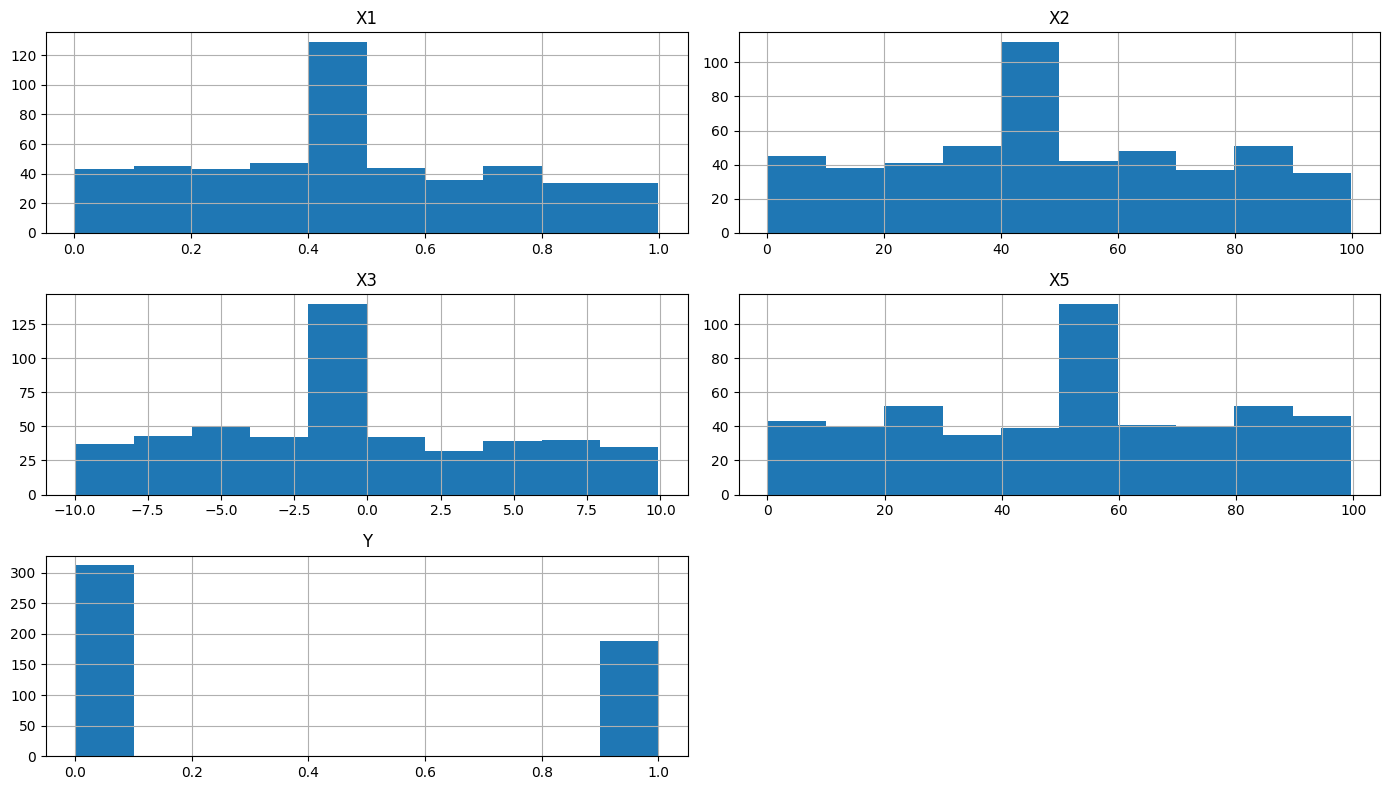

/tmp/ipykernel_6200/713116898.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()
/tmp/ipykernel_6200/713116898.py:9: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,X1,X2,X3,X5,Y
X1,1.00,-0.02,0.01,0.02,-0.01
X2,-0.02,1.00,-0.05,0.05,-0.20
X3,0.01,-0.05,1.00,0.03,-0.05
X5,0.02,0.05,0.03,1.00,-0.03
Y,-0.01,-0.20,-0.05,-0.03,1.00


In [5]:
from matplotlib import pyplot as plt
# Histogrami vseh spremenljivk
df.hist(figsize=(14,8))
plt.tight_layout()
plt.show()

# Korelacijska matrika
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

A.5: V nadaljevanju bomo za strojno učenje uporabljali knjižnico **scikit-learn**, ki ima pomembno omejitev: direktno ne podpira kategoričnih značilk, kot je X4 v naših podatkih. Reši to zagato z uporabo kodirnika **sklearn.preprocessing.OneHotEncoder**.

In [6]:
from sklearn.preprocessing import OneHotEncoder

# Izberimo le kategorične stolpce
categorical_cols = df.columns[df.dtypes=="object"]

# Ustvarimo enkoder za kodiranje
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
# Izvedimo kodiranje
OH_cols = OH_encoder.fit_transform(df[categorical_cols])

# Sestavimo dataframe, z enkodiranimi stolpci namesto originalnih
OH_cols = pd.DataFrame(OH_cols, columns = OH_encoder.get_feature_names_out())
OH_cols.index = df.index
numeric_data = df.drop(categorical_cols, axis=1)
data = pd.concat([OH_cols, numeric_data], axis=1)

# Preverimo
print(data.head())


   X4_bike  X4_car  X4_train        X1         X2        X3         X5  Y
1      0.0     1.0       0.0  0.452553  69.113756 -2.558555  23.210163  1
2      1.0     0.0       0.0  0.865373  39.855286 -0.727901  24.136736  0
3      1.0     0.0       0.0  0.480240  82.321769 -6.092819  70.441331  0
4      0.0     1.0       0.0  0.568116  82.638111 -8.248877  50.498433  1
5      0.0     1.0       0.0  0.936621  34.460152 -9.577684  46.773121  0


/home/tadej/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### B Strojno učenje s scikit-learn: binarna klasifikacija

B.1: Na celotnih podatkih natreniraj model najbližjih sosedov (**sklearn.neighbors.KNeighborsClassifier**).

In [7]:
from sklearn.neighbors import KNeighborsClassifier

X = data.drop("Y", axis=1)
y = data["Y"]

# Instanciramo model
knn = KNeighborsClassifier(2)
# Naučimo model
knn.fit(X, y)


KNeighborsClassifier(n_neighbors=2)

B.2: Izračunaj natančnost modela na učni množici (celotnih podatkih).

In [8]:
# Izračunamo napovedi
predictions = knn.predict(X)
# Izračunamo napako
accuracy = np.sum(y == predictions)/len(y)
print("Natančnost: ", accuracy)

Natančnost:  0.806


B.3: Ocena na učnih podatkih ni dovolj dobra, saj nam ne zagotavlja, da bo model dobro deloval na novih podatkih. Model lahko preprosto zapomni vse podatke v učni množici, vendar ne bo deloval dobro na novih podatkih. Boljša metoda bi bila, da model preskusimo na novih podatkih. Da oceniš sposobnost generaliziranja, razdeli podatke podatkov na učno in testno množico v razmerju 4:1. Pri tem si lahko pomagaš s funkcijo **sklearn.validation.train_test_split**. 
Potem na novo natreniraj model na učni množici ter izračunaj njegovo natančnost na testni množici.

Opomba: deljenje na učno in testno množico vključuje element naključnosti. Za ponovljive poskuse moramo nastaviti seme naključnega generatorja, npr. **np.random.seed(0)**.

In [9]:
from sklearn.model_selection import train_test_split

# Nastavimo seme
np.random.seed(0)
# Razdelimo podatke
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

predictions = knn.predict(X_test)
accuracy = np.sum(y_test == predictions)/len(y_test)
print(accuracy)

0.59


B.4: Se ti zdi, da model deluje dobro? 
Metoda najbližjih sosedov je lahko občutljiva na relativne magnitude značilk. Poskusi podatke skalirati z standardno transformacijo $x_i' = \frac{x_i-\bar{x_i}}{\sigma_{x_i}}$. Pomagaš si lahko s **sklearn.preprocessing.StandardScaler**.
Metoda najbližjih sosedov ima tudi en pomemben *hiperparameter*: število sosedov. Nariši graf odvisnosti natančnosti modela (na skaliranih podatkih) v odvisnosti od števila sosedov 1-30. Katero je najboljše?

Text(0, 0.5, 'natančnost')

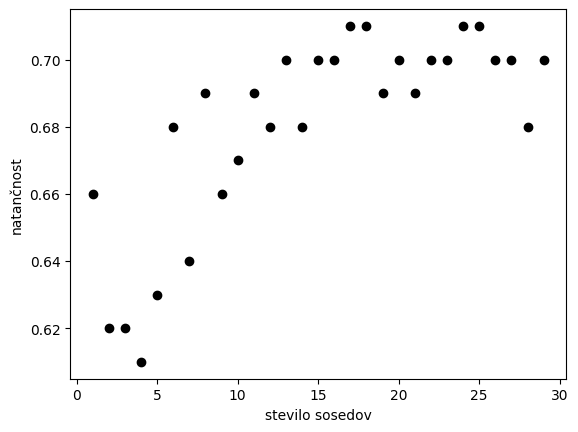

In [10]:
from sklearn.preprocessing import StandardScaler

# Skaliramo podatke
scaler = StandardScaler()
Xtrain_sc = scaler.fit_transform(X_train)
Xtest_sc = scaler.transform(X_test)

acc = []
k_all = list(range(1, 30))
# Zanka, ki teče po številih sosedov, definiranih v k_all
for k in k_all:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(Xtrain_sc, y_train)
    pred = knn.predict(Xtest_sc)
    accuracy = np.sum(y_test == pred)/len(y_test)
    acc += [accuracy]

plt.plot(k_all, acc, "ko")
plt.xlabel("stevilo sosedov")
plt.ylabel("natančnost")

B.5: Natančnost je mera uspešnosti, ki se pogosto uporablja pri klasifikacijskih problemih. V našem primeru imamo poseben primer klasifikacije, pri katerem ima ciljna spremenljivka samo dva razreda: binarna klasifikacija. Kadar je porazdelitev razredov v podatkih neenakomerna, natančnost ni več dobra mera. V takih primerih si pomagamo z matriko zmede (confusion matrix), preciznostjo in priklicem (precision and recall), ROC krivuljo (ROC curve) ter ploščino pod le-to (ROC-AUC). Izpiši vse našteto za KNN z izbranim k (vsaj 10).

Confusion matrix: 
[[52  7]
 [22 19]]
Report:
              precision    recall  f1-score   support

           0       0.70      0.88      0.78        59
           1       0.73      0.46      0.57        41

    accuracy                           0.71       100
   macro avg       0.72      0.67      0.67       100
weighted avg       0.71      0.71      0.69       100

Ploscina pod ROC krivuljo:
0.7422488631665978


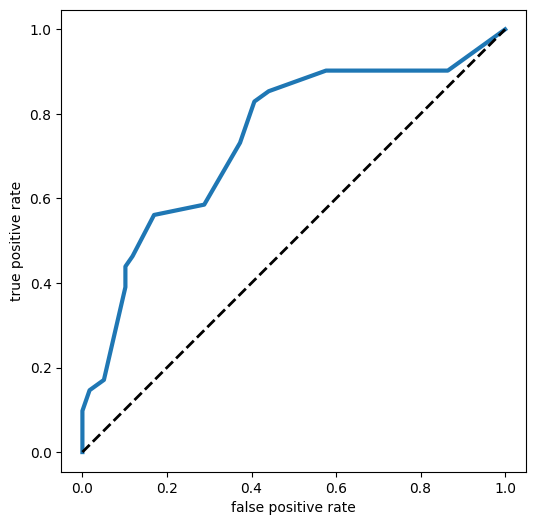

In [11]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(Xtrain_sc, y_train)
pred = knn.predict(Xtest_sc)
# Nekatere metrike potrebujejo napovedi v obliki verjetnosti pozitivnega razreda.
# Pozor: vse metode strojnega učenja ne podpirajo napovedovanja verjetnosti.
pred_prob = knn.predict_proba(Xtest_sc)

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report

print("Confusion matrix: ")
print(confusion_matrix(y_test, pred))

print("Report:")
print(classification_report(y_test, pred))

print("Ploscina pod ROC krivuljo:")
print(roc_auc_score(y_test, pred_prob[:,1]))

# Izračunamo ROC krivuljo
fpr, tpr, thr = roc_curve(y_test, pred_prob[:,1])

# Nariščemo ROC krivuljo
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, lw=3)
plt.plot([0,1], [0,1], "k--", lw=2)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.axis("equal")
plt.show()

B.DODATNO: Preizkusi še nekaj drugih metod strojnega učenja, npr. logistično regresijo (**sklearn.linear_model.LogisticRegression**), odločitveno drevo (**sklearn.tree.DecisionTreeClassifier**), naključni gozd (**sklearn.ensemble.RandomForestClassifier**) ter metodo podpornih vektorjev (**sklearn.svm.SVC**).

### C: regresija - napovedovanje numerične ciljne spremenljivke
Za nalogo regresije uporabljamo druge metode strojnega učenja kot za klasifikacijo, vendar pa med njimi pogosto obstajajo analogije.
Drugačne so tudi metrike za računanje napake in uspešnosti modelov. Pri regresiji so koristne metrike MSE, RMSE, $R^2$, NMSE, itd.

C.1: Naloži podatke v datoteki "podatki_regresija.csv". Napovedna spremenljivka se imenuje "target", tokrat so podatki že očiščeni. Nauči model linearne regresije (**sklearn.linear_model.LinearRegression**) ter izračunaj njegov RMSE ter $R^2$.

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Naložimo podatke iz CSV datoteke
data = pd.read_csv("podatki_regresija.csv")

# Ločimo vektor tarčnih vrednosti od matrike značilk
y = data["target"]
X = data.drop("target", axis=1)

# Razdelimo podatke na učno in testno množico
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Naučimo model linearne regresije
model = LinearRegression()
model.fit(X_train, y_train)

# Izračunamo napovedi za testno množico
y_pred = model.predict(X_test)

# Izračunamo RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Izračunamo R^2
r2 = r2_score(y_test, y_pred)

# Izpišemo rezultate
print("RMSE: ", rmse)
print("R^2: ", r2)


RMSE:  58.517661335820094
R^2:  0.3322220326906514


C.2: Delitev na učno in testno množico ni slab pristop, boljšo oceno napake pa lahko pridobimo s prečnim preverjanjem (k-fold cross-validation). Pri tem postopku podatke razdelimo na k (tipično 5 ali 10) enakih delov. Kot učno množico uporabimo vse razen enega dela, ki služi kot testna množica. Ta postopek izvedemo k-krat, pri čemer na vsaki iteraciji za testno množico razglasimo drug del podatkov. Ponavadi na koncu napake povprečimo. Ker pri prečnem preverjanju učimo model k-krat, je lahko ta postopek zamuden, če imamo zelo veliko podatkov in/ali počasno metodo strojnega učenja.

Z metodo 5-kratnega prečnega preverjanja preizkusi vsaj 3 različne metode ter določi, katera je najboljša za naše podatke. Nekaj predlogov: linearna regresija, podporni vektorji (**sklearn.svm.SVR**), naključni gozd (**sklearn.ensemble.RandomForestRegressor**), najbližji sosedi (**sklearn.neighbor.KNeighborsRegressor**). Pomagaš si lahko s funkcijo **sklearn.model_selection.cross_validate** (preprosta) ali **sklearn.model_selection.KFold** (več nadzora).

In [13]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

models = {"LR": LinearRegression(), "SVR": SVR(), "RF": RandomForestRegressor(), "KNN5": KNeighborsRegressor(5), "KNN10": KNeighborsRegressor(10)}
cv_method = "KFold"

r2_all = []
np.random.seed(0)

# 1. možnost: uporaba cross_validate, nam olajša delo
if cv_method == "cross_validate":
    # zanka po modelih
    for name, model in models.items():
        result = cross_validate(model, X, y, cv=5, scoring="r2")
        r2_mean = result["test_score"].mean()
        r2_all += [r2_mean]
        print("r2 za ", name, ": ", r2_mean)

# 2. možnost: uporaba KFold, ki nam zgolj vrne indekse za posamezne iteracije in nam omogoči eksplicitni nadzor nad dogajanjem
elif cv_method == "KFold":
    # zanka po modelih
    for name, model in models.items():
        CV = KFold(5)
        r2 = []
        # zanka po iteracijah prečnega preverjanja
        for train_ind, test_ind in CV.split(X):
            model.fit(X.iloc[train_ind,:], y.iloc[train_ind])
            pred = model.predict(X.iloc[test_ind,:])
            r2 += [r2_score(y.iloc[test_ind], pred)]

        r2_mean = np.mean(r2)
        r2_all += [r2_mean]
        print("r2 za ", name, ": ", r2_mean)

best_i = np.argmax(r2_all)
print("Najboljša izbira je ", list(models.keys())[best_i])

r2 za  LR :  0.48231812211149394
r2 za  SVR :  0.14680946577304235
r2 za  RF :  0.424236610518281
r2 za  KNN5 :  0.37650814581101094
r2 za  KNN10 :  0.4283905878634148
Najboljša izbira je  LR
